In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

DATA GATHERING (AYALA STOCK MARKET)

In [291]:
data = yf.download(tickers = 'AC', start='2012-03-11', end='2023-07-11')

[*********************100%***********************]  1 of 1 completed


In [292]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-10,26.069653,27.572140,26.069653,27.572140,26.448412,1105
2015-11-11,27.572140,27.572140,27.572140,27.572140,26.448412,0
2015-11-12,27.572140,27.572140,27.572140,27.572140,26.448412,0
2015-11-13,27.572140,27.572140,27.572140,27.572140,26.448412,0
2015-11-16,26.666668,26.666668,26.666668,26.666668,25.579844,301


In [293]:
len(data)

1927

ADDING RSI, and Technical Indicators

In [294]:
data['RSI'] =ta.rsi(data.Close, length=30)
data['EMAF'] =ta.ema(data.Close, length=50)
data['EMAM'] =ta.ema(data.Close, length=100)
data['EMAS'] =ta.ema(data.Close, length=150)

Cleaning Data and Adding Target CLose Price

In [295]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data['TargetNextClose'] = data['Adj Close'].shift(-1)
data.drop(['Close', 'Volume', 'Date'], axis=1, inplace=True)

Scaling Data

In [296]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

data_scaled =  scaler.fit_transform(data)
data_scaled.shape[0]
data_scaled_df = pd.DataFrame(data_scaled, columns=['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'TargetNextClose'])
data_scaled_df

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,0.079157,0.057667,0.133249,0.059590,0.224229,0.020337,0.009011,0.000717,0.057230
1,0.073246,0.055832,0.138301,0.057230,0.212840,0.018209,0.008093,0.000532,0.070865
2,0.076587,0.064744,0.146511,0.070865,0.288309,0.017656,0.008052,0.000957,0.071651
3,0.092521,0.070511,0.155036,0.071651,0.292475,0.017210,0.008062,0.001412,0.069816
4,0.090722,0.057929,0.147774,0.069816,0.282806,0.016582,0.007955,0.001778,0.070865
...,...,...,...,...,...,...,...,...,...
1773,0.251813,0.222229,0.344659,0.268909,0.223773,0.524868,0.647422,0.749663,0.240983
1774,0.237607,0.207741,0.322445,0.240983,0.158254,0.519195,0.643213,0.746176,0.248923
1775,0.223401,0.206687,0.323398,0.248923,0.181942,0.514581,0.639569,0.743075,0.255220
1776,0.230634,0.211165,0.326412,0.255220,0.200637,0.510811,0.636379,0.740286,0.251387


Setting Backcandles Input

In [297]:
X = []
backcandles = 20
for i in range(8):
    X.append([])
    for j in range(backcandles, data_scaled.shape[0]):
        X[i].append(data_scaled[j-backcandles:j, i])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_scaled[backcandles:, -1])
y = np.reshape(yi, (len(yi), 1))

In [298]:
X.shape

(1758, 20, 8)

In [299]:
def split_array(x_array, y_array, training_percent):
    splitlimit = int(len(X)*training_percent)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]
    
    return X_train, y_train, X_test, y_test

In [300]:
X_train, y_train, X_test, y_test = split_array(X, y, .8)

Training Model

In [301]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation

In [302]:
lstm_input = Input(shape=(X.shape[1], X.shape[2]), name='lstm_input')
inputs = LSTM(100, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name= 'output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=50, shuffle=True, validation_split=0.1, verbose=0)

Real vs Predictions

In [303]:
X_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 0s 4ms/step
[0.3072867] [0.32296275]
[0.3196762] [0.34550235]
[0.30391192] [0.32920872]
[0.30853245] [0.33029489]
[0.28644532] [0.30558306]
[0.3108488] [0.32948027]
[0.32049578] [0.34604533]
[0.3113599] [0.35039031]
[0.3656299] [0.39981407]
[0.33384043] [0.3626105]


PLOTTING THE REAL VS PREDICTIONS

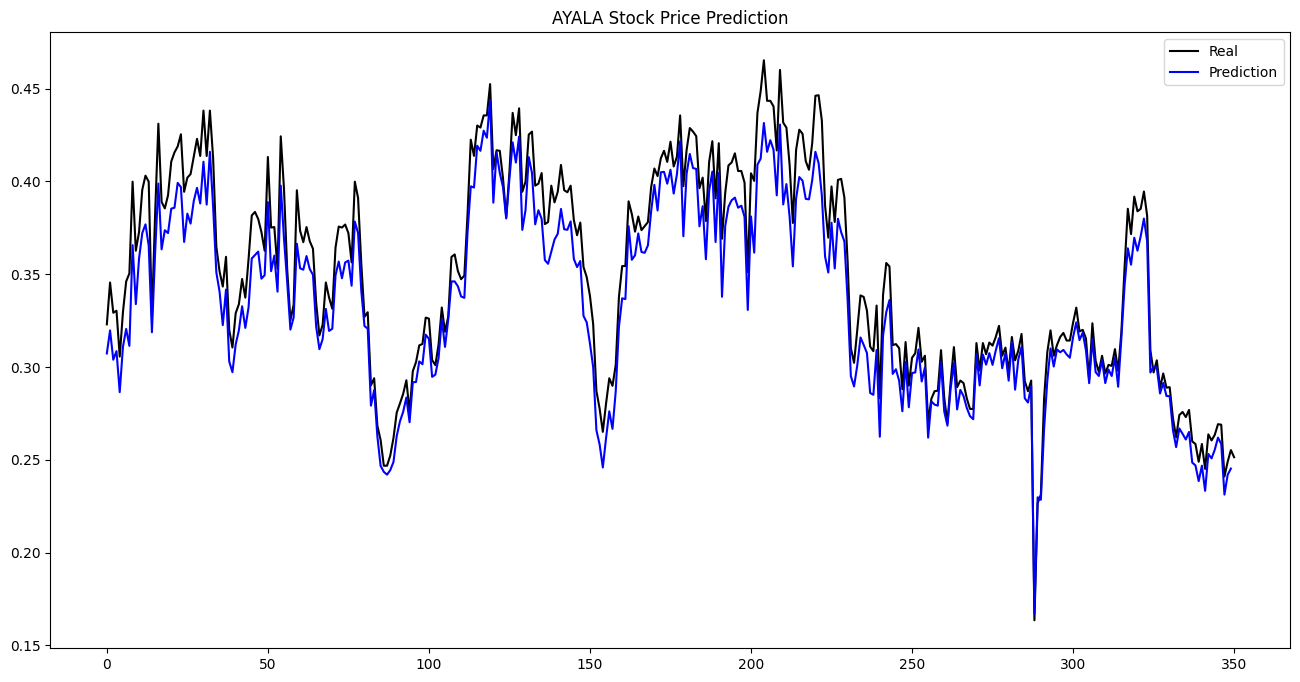

In [305]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Prediction')
plt.title('AYALA Stock Price Prediction')
plt.legend()
plt.show()